# 1. Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import os
import cv2
import warnings
from utils import save_to_csv, save_encoder, download_data
warnings.filterwarnings('ignore')

0it [00:00, ?it/s]
C:\Users\Anh\PycharmProjects\Capstone_project-Breast_Cancer_Classification\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Data Exploration

In [2]:
download_data() #Download data and save in specific path for future use
df = pd.read_csv('../Datasets/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
df.head()

Cache path: C:\Users\Anh\.cache\kagglehub\datasets\kmader\skin-cancer-mnist-ham10000\versions\2
Dataset already exists at: ../Datasets/skin-cancer-mnist-ham10000


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


Create a backup copy of the main dataframe.

In [3]:
df_backup = df.copy() 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


Find NaN

In [5]:
df.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

we found out that column 'age' has 57 NaN values

In [6]:
col_to_explore = ["dx", "dx_type", "sex", "localization"]

for c in col_to_explore:
  print(f"Unique values of col '{c}': {df[c].unique()}")

Unique values of col 'dx': ['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']
Unique values of col 'dx_type': ['histo' 'consensus' 'confocal' 'follow_up']
Unique values of col 'sex': ['male' 'female' 'unknown']
Unique values of col 'localization': ['scalp' 'ear' 'face' 'back' 'trunk' 'chest' 'upper extremity' 'abdomen'
 'unknown' 'lower extremity' 'genital' 'neck' 'hand' 'foot' 'acral']


we found out that column 'sex' and 'localization' has 'unknown' value

In [7]:
df['sex'].value_counts()

sex
male       5406
female     4552
unknown      57
Name: count, dtype: int64

In [8]:
df['localization'].value_counts()

localization
back               2192
lower extremity    2077
trunk              1404
upper extremity    1118
abdomen            1022
face                745
chest               407
foot                319
unknown             234
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: count, dtype: int64

In [9]:
df['localization'].unique()

array(['scalp', 'ear', 'face', 'back', 'trunk', 'chest',
       'upper extremity', 'abdomen', 'unknown', 'lower extremity',
       'genital', 'neck', 'hand', 'foot', 'acral'], dtype=object)

We will replace 'unknown' values with NaN and fill in later.

In [10]:
df['sex'].replace('unknown', np.nan, inplace = True)
df['localization'].replace('unknown', np.nan, inplace = True)

In [11]:
df[['sex', 'localization']].isna().sum()

sex              57
localization    234
dtype: int64

Text(0.5, 1.0, 'Distribution of localization')

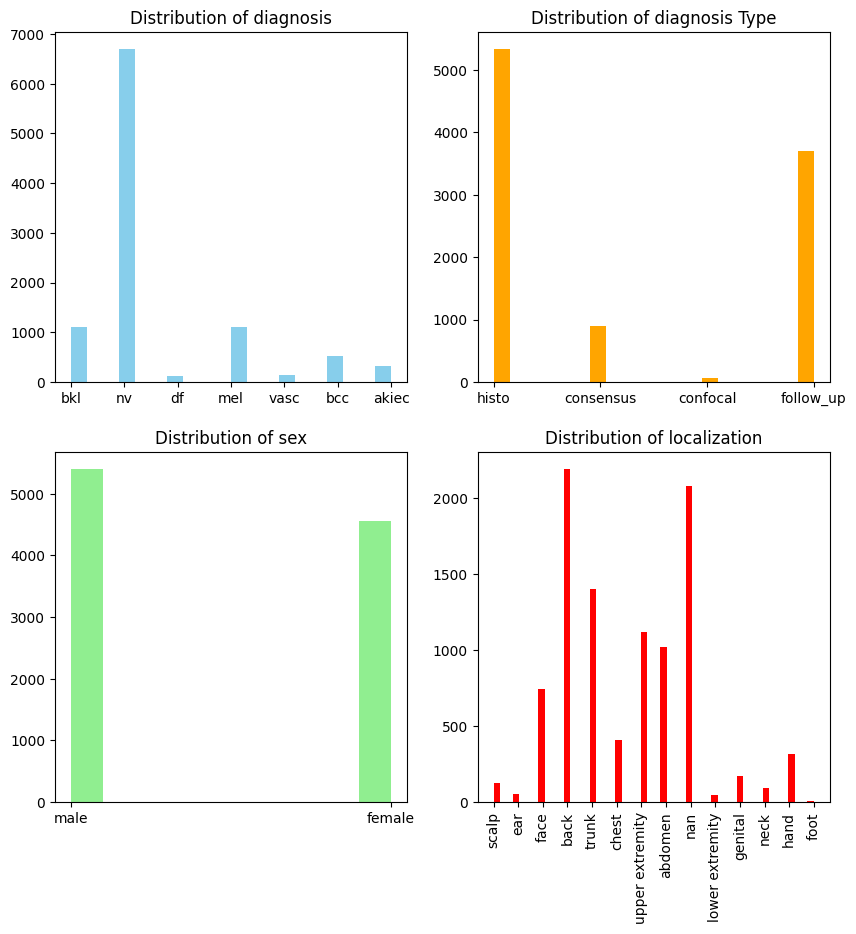

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

df['dx'].hist(bins=20, ax=axes[0,0], color='skyblue')
axes[0,0].grid(False)
axes[0,0].set_title("Distribution of diagnosis")

df['dx_type'].hist(bins=20, ax=axes[0,1], color='orange')
axes[0,1].grid(False)
axes[0,1].set_title("Distribution of diagnosis Type")

df['sex'].hist(ax=axes[1,0], color='lightgreen')
axes[1,0].grid(False)
axes[1,0].set_title("Distribution of sex") 

df['localization'].hist(bins=50, ax=axes[1,1], color='red')
axes[1,1].grid(False)
axes[1,1].set_xticklabels(df['localization'].unique(), rotation=90)
axes[1,1].set_title("Distribution of localization")

# There are still NaN values that were not plotted, but since they are insignificant, I will ignore them

# 3. Data Preprocessing

In [13]:
df.isna().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex              57
localization    234
dtype: int64

In [14]:
age_imputer = SimpleImputer(strategy='mean')
df['age'] = age_imputer.fit_transform(df[['age']])[:, 0]

In [15]:
sex_imputer = SimpleImputer(strategy='most_frequent')
df['sex'] = sex_imputer.fit_transform(df[['sex']])[:, 0]

In [16]:
localization_imputer = SimpleImputer(strategy='most_frequent')
df['localization'] = localization_imputer.fit_transform(df[['localization']])[:, 0]

Create a new column ‘diagnose’ as a substitute for ‘dx’.

In [17]:
dx_dict = {
    "nv": "Melanocytic nevi",
    "mel": "Melanoma",
    "bkl": "Benign keratosis-like lesions",
    "bcc": "Basal cell carcinoma",
    "akiec": "Actinic keratoses",
    "vasc": "Vascular lesions",
    "df": "Dermatofibroma"
}

df["diagnose"] = df["dx"].map(dx_dict)

Since the ‘dx’ column is no longer needed, I will drop it along with the columns ‘lesion_id’. ‘image_id’ will be preprocessing later in another notebook, but I will keep it to merge 2 csv later.

In [18]:
df.drop(["dx", "lesion_id"], axis=1, inplace=True)

Create 'label' column based on 'diagnose'. 1 is cancer, 0 is not cancer

In [19]:
label = [1 if each == 'Melanoma' or each == 'Basal cell carcinoma' 
         or each == 'Actinic keratoses' or each == 'Vascular lesions' 
         else 0 for each in df.diagnose]

In [20]:
df['label'] = label

In [21]:
df['label'].value_counts()

label
0    7919
1    2096
Name: count, dtype: int64

In [22]:
df['diagnose'].value_counts()

diagnose
Melanocytic nevi                 6705
Melanoma                         1113
Benign keratosis-like lesions    1099
Basal cell carcinoma              514
Actinic keratoses                 327
Vascular lesions                  142
Dermatofibroma                    115
Name: count, dtype: int64

Encoding data with Label Encoder

In [23]:
dx_type_label_encoder = LabelEncoder()
sex_cat_label_encoder = LabelEncoder()
localization_cat_encoder = LabelEncoder()
diagnose_cat_label_encoder = LabelEncoder()

In [24]:
dx_type = dx_type_label_encoder.fit_transform(df["dx_type"])
dx_type = pd.DataFrame(dx_type, columns=["dx_type"])

sex_cat = sex_cat_label_encoder.fit_transform(df["sex"])
sex_cat = pd.DataFrame(sex_cat, columns=["sex"])

localization_cat = localization_cat_encoder.fit_transform(df["localization"])
localization_cat = pd.DataFrame(localization_cat, columns=["localization"])

diagnose_cat = diagnose_cat_label_encoder.fit_transform(df["diagnose"])
diagnose_cat = pd.DataFrame(diagnose_cat, columns=["diagnose"])

In [25]:
encoders = [sex_cat_label_encoder, localization_cat_encoder, diagnose_cat_label_encoder]
names = ['sex_cat_label_encoder', 'localization_cat_encoder', 'diagnose_cat_label_encoder']

for idx, e in enumerate(encoders):
    save_encoder(e, f"../Encoders/{names[idx]}.joblib")

Model is existed at ../Encoders/sex_cat_label_encoder.joblib
Model is existed at ../Encoders/localization_cat_encoder.joblib
Model is existed at ../Encoders/diagnose_cat_label_encoder.joblib


In [26]:
df['sex'] = sex_cat
df['localization'] = localization_cat
df['diagnose'] = diagnose_cat
df['dx_type'] = dx_type

Save the processed DataFrame

In [27]:
save_to_csv(df, "processed_data.csv")

File 'csv\processed_data.csv' is existed
